In [1]:
!gdown "1Y8_gEkZpkmC3vGQreYk_CTr5BGtkRKDn"

Downloading...
From (original): https://drive.google.com/uc?id=1Y8_gEkZpkmC3vGQreYk_CTr5BGtkRKDn
From (redirected): https://drive.google.com/uc?id=1Y8_gEkZpkmC3vGQreYk_CTr5BGtkRKDn&confirm=t&uuid=f0358d39-a4d8-4492-934b-df79a7fba662
To: /kaggle/working/high-resolution-captioned-image-dataset-512x512.zip
100%|████████████████████████████████████████| 408M/408M [00:05<00:00, 80.1MB/s]


In [ ]:
!unzip ./high-resolution-captioned-image-dataset-512x512.zip

In [ ]:
!mkdir -p ./dataset
!mv general nature people travel dataset

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
dataset_transforms = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop((512, 512))
])

dataloader_transforms = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.ImageFolder(
    root="./dataset",
    transform=dataset_transforms
)

dataloader = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.ImageFolder(
        root="./dataset",
        transform=dataloader_transforms
    ),
    batch_size=4,
    shuffle=True,
    num_workers=4
)

dataset[0]

(<PIL.Image.Image image mode=RGB size=512x512>, 0)

In [40]:
def q_sample(x0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod):
    noise = torch.randn_like(x0)
    sqrt_alpha_cumprod_t = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
    return sqrt_alpha_cumprod_t * x0 + sqrt_one_minus_alpha_cumprod_t * noise, noise

In [41]:
def get_noise_schedule(T, beta_start=1e-4, beta_end=0.02):
    betas = torch.linspace(beta_start, beta_end, T)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)
    return betas, alphas, alphas_cumprod, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod

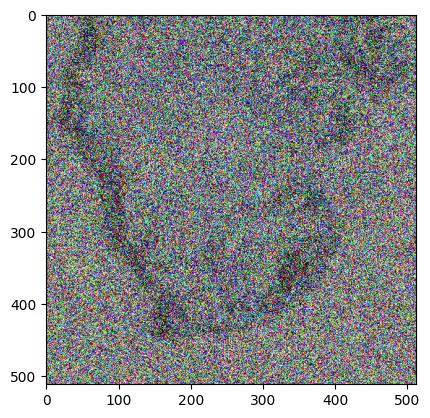

In [42]:
T = 1000
betas, alphas, alphas_cumprod, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod = get_noise_schedule(T)

image = q_sample(transforms.ToTensor()(dataset[0][0]), 300, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)[0].squeeze().permute(1, 2, 0)

plt.imshow(image)

In [43]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim=None):
        super().__init__()

        self.norm1 = nn.GroupNorm(8, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.norm2 = nn.GroupNorm(8, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.time_emb_proj = None
        if time_emb_dim is not None:
            self.time_emb_proj = nn.Linear(time_emb_dim, out_channels)

        self.residual_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
    
    def forward(self, X, t_emb=None):
        h = F.silu(self.norm1.forward(X))
        h = self.conv1.forward(h)

        if self.time_emb_proj is not None and t_emb is not None:
            time_emb = self.time_emb_proj.forward(t_emb).view(t_emb.size(0), -1, 1, 1)
            h = h + time_emb

        h = F.silu(self.norm2.forward(h))
        h = self.conv2.forward(h)
        
        return h + self.residual_connection(X)

In [44]:
class DownsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim=None):
        super().__init__()
        self.resblock = ResidualBlock(in_channels, out_channels, time_emb_dim)
        self.downsample = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1)

    def forward(self, X, t_emb=None):
        X = self.resblock.forward(X, t_emb)
        X_down = self.downsample.forward(X)
        return X_down, X

In [45]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, time_emb_dim=None):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        self.resblock = ResidualBlock(out_channels + skip_channels, out_channels, time_emb_dim)
    
    def forward(self, X, skip, t_emb=None):
        X = self.upsample.forward(X)
        X = torch.cat([X, skip], dim=1)
        X = self.resblock.forward(X, t_emb)
        return X

In [46]:
image = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3).forward(TF.to_tensor(dataset[0][0]))
image.shape

torch.Size([8, 510, 510])

In [47]:
block = DownsampleBlock(in_channels=8, out_channels=16)
out, skip = block.forward(image.unsqueeze(0))
out.shape

torch.Size([1, 16, 255, 255])

In [48]:
block = UpsampleBlock(in_channels=16, skip_channels=16, out_channels=8)
block.forward(out, skip).shape

torch.Size([1, 8, 510, 510])

In [49]:
def get_timestep_embedding(timesteps, dim):
    device = timesteps.device
    half = dim // 2
    emb = torch.exp(torch.arange(half, device=device) * -(torch.log(torch.tensor(10000)) / half))
    emb = timesteps[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
    return emb

get_timestep_embedding(torch.arange(0, 1000), torch.tensor(784))

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.8415,  0.8287,  0.8158,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.9093,  0.9276,  0.9436,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [-0.8980, -0.0459,  0.6205,  ...,  0.9943,  0.9945,  0.9948],
        [-0.8555,  0.8021, -0.2809,  ...,  0.9943,  0.9945,  0.9948],
        [-0.0265,  0.9438, -0.9454,  ...,  0.9943,  0.9945,  0.9948]])

In [50]:
class UNet(nn.Module):
    def __init__(self, input_channels=3, base_channels=64, channel_mults=(1, 2, 4, 8), num_res_blocks=1, time_emb_dim=128):
        super().__init__()

        self.input_proj = nn.Conv2d(input_channels, base_channels, kernel_size=3, padding=1)

        self.down_blocks = nn.ModuleList()
        in_channels = base_channels
        skip_channels = []
        for mult in channel_mults:
            out_channels = base_channels * mult
            self.down_blocks.append(DownsampleBlock(in_channels, out_channels))
            skip_channels.append(out_channels)
            in_channels = out_channels

        self.bottleneck = nn.Sequential(
            *[ResidualBlock(in_channels, in_channels) for _ in range(num_res_blocks)]
        )

        self.up_blocks = nn.ModuleList()
        for mult, skip_ch in zip(reversed(channel_mults), reversed(skip_channels)):
            out_channels = base_channels * mult // 2
            self.up_blocks.append(UpsampleBlock(in_channels, skip_ch, out_channels))
            in_channels = out_channels
        
        self.output_proj = nn.Sequential(
            ResidualBlock(in_channels, in_channels),
            nn.Conv2d(in_channels, input_channels, kernel_size=1)
        )

        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

    def forward(self, X, t):
        X = self.input_proj.forward(X)

        t_emb = get_timestep_embedding(t, self.time_mlp[0].in_features)
        t_emb = self.time_mlp.forward(t_emb)

        skips = []
        for block in self.down_blocks:
            X, skip = block.forward(X)
            skips.append(skip)
        
        X = self.bottleneck.forward(X)

        for block, skip in zip(self.up_blocks, reversed(skips)):
            X = block.forward(X, skip)
        
        X = self.output_proj.forward(X)
        return X

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(input_channels=3, base_channels=64).to(device)

X = TF.to_tensor(dataset[0][0]).unsqueeze(0).to(device)
t = torch.randint(0, T, (X.size(0),)).to(device)
out = model.forward(X, t)
out.shape

torch.Size([1, 3, 512, 512])

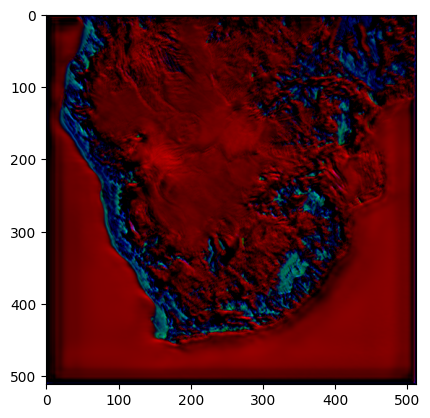

In [52]:
image = out.squeeze().permute(1, 2, 0).detach().cpu()
plt.imshow(image)

In [53]:
model = UNet(
    input_channels=3,
    base_channels=64,
    channel_mults=(1, 2, 4, 8),
    num_res_blocks=1,
    time_emb_dim=128
).to(device)

model.load_state_dict(torch.load("model.pth", map_location=device))

optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=1e-4
)

criterion = nn.MSELoss()

num_epochs = 4

In [54]:
def train_step(model, x0, t, alphas_cumprod, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod):
    model.train()

    noise = torch.randn_like(x0)
    sqrt_ac = sqrt_alphas_cumprod.to(device)[t].view(-1, 1, 1, 1)
    sqrt_omac = sqrt_one_minus_alphas_cumprod.to(device)[t].view(-1, 1, 1, 1)
    x_t = sqrt_ac * x0 + sqrt_omac * noise

    pred = model.forward(x_t, t)

    loss = criterion(pred, noise)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
optimizer.param_groups[0]["lr"] = 1e-5

In [ ]:
for epoch in range(1, num_epochs**10+1):
    losses = []
    for batch, (image, _) in enumerate(dataloader, 1):
        image = image.to(device)
        t = torch.randint(0, T, (image.size(0),), device=device)

        loss = train_step(model, image, t, alphas_cumprod, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
        losses.append(loss)

        if batch % 10 == 0:
            avg_loss = sum(losses) / len(losses)
            print(f"[Epoch {epoch}] Step {batch}: {avg_loss:.4f}")

In [62]:
torch.save(model.state_dict(), "model.pth")

In [55]:
@torch.no_grad()
def sample_ddpm(model, img_size, num_steps=1000, count=4, device="cpu"):
    model.eval()
    B = count
    X = torch.randn(B, 3, img_size, img_size, device=device)

    for t in tqdm.tqdm(reversed(range(1, num_steps)), total=num_steps-1):
        t_batch = torch.full((B,), t, device=device, dtype=torch.long)

        pred_noise = model.forward(X, t_batch)

        alpha = alphas[t]
        alpha_bar = alphas_cumprod[t]
        alpha_bar_prev = alphas_cumprod[t - 1] if t > 1 else torch.tensor(1.0, device=device)

        beta = 1 - alpha
        coef1 = 1 / torch.sqrt(alpha)
        coef2 = beta / torch.sqrt(1 - alpha_bar)

        mean = coef1 * (X - coef2 * pred_noise)

        if t > 1:
            noise = torch.randn_like(X)
            sigma = torch.sqrt((1 - alpha_bar_prev) / (1 - alpha_bar) * beta)
            X = mean + sigma * noise
        else:
            X = mean
            
    return X

In [ ]:
for i in range(0, 100):
    with torch.inference_mode():
        images = sample_ddpm(model, img_size=1024, num_steps=1000, count=1, device=device)
        images += abs(images.min())
        images /= images.max()
    
    plt.imshow(images[0].cpu().permute(1, 2, 0))
    plt.axis(False)
    plt.show()
    
    TF.to_pil_image(images[0].cpu()).save(f"1024-{i:0>2}.jpg")

  0%|          | 0/999 [00:00<?, ?it/s]

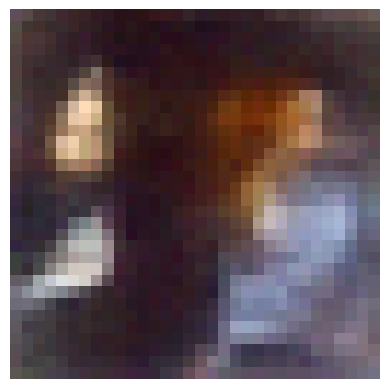

In [58]:
with torch.inference_mode():
    images = sample_ddpm(model, img_size=32, num_steps=1000, count=1, device=device)
    images += abs(images.min())
    images /= images.max()

plt.imshow(images[0].cpu().permute(1, 2, 0))
plt.axis(False)
plt.show()

  0%|          | 0/999 [00:00<?, ?it/s]

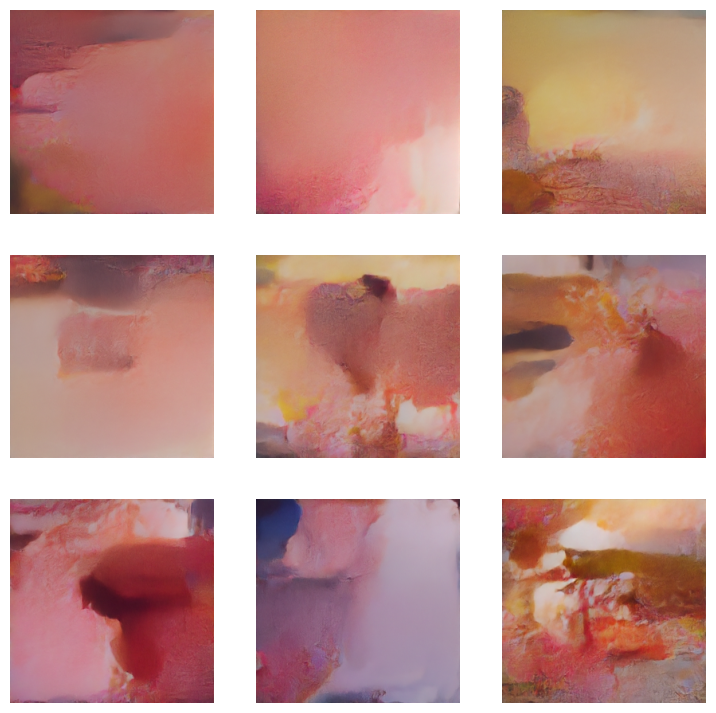

In [60]:
with torch.inference_mode():
    images = sample_ddpm(model, img_size=256, num_steps=1000, count=9, device=device)
    images += abs(images.min())
    images /= images.max()

plt.figure(figsize=(9, 9))
for i in range(0, len(images)):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].cpu().permute(1, 2, 0))
    plt.axis(False)

  0%|          | 0/999 [00:00<?, ?it/s]

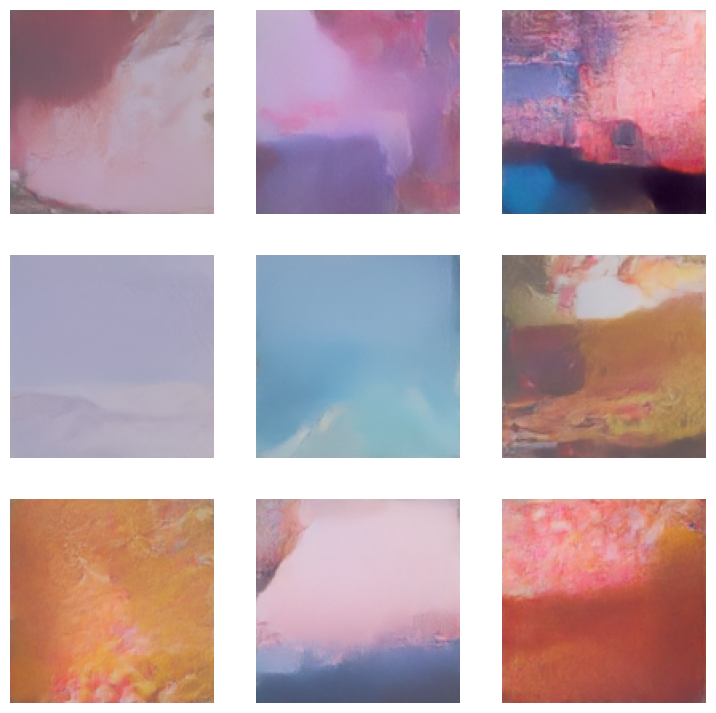

In [59]:
with torch.inference_mode():
    images = sample_ddpm(model, img_size=128, num_steps=1000, count=9, device=device)
    images += abs(images.min())
    images /= images.max()

plt.figure(figsize=(9, 9))
for i in range(0, len(images)):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].cpu().permute(1, 2, 0))
    plt.axis(False)